# Face Recognition using VGG16 and SIFT descriptors
based on paper: Face Recognition Using the SR-CNN Model

# Import libraries

In [1]:
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, regularizers, utils
from tensorflow.keras import applications
from tensorflow.keras.losses import categorical_crossentropy,categorical_hinge,hinge,squared_hinge
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization , Input ,concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import  EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split

import cv2

import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from datetime import datetime
import io
import itertools
from packaging import version



from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

import sklearn.metrics
from tensorflow.keras.optimizers import SGD


np.random.seed(1000)
# Load the TensorBoard notebook extension
%load_ext tensorboard


In [2]:
def normalize_mean_var(arr):
    arr -= np.mean(arr)
    arr /= np.var(arr)
    return arr

In [3]:
# load only persons with more than 100
number_of_images = 40
iter_csv = pd.read_csv("LFW/lfw_allnames.csv", iterator=True, chunksize=1000)
df = pd.concat([chunk[chunk['images'] > number_of_images] for chunk in iter_csv])

topNames = set([x for x in df['name']])
#names.add('Bshara')
len(topNames)

19

# Prepare data

Generators

In [4]:
import math
class my_gen_extra(tf.keras.utils.Sequence):

    def __init__(self, data_path):
        
        self.data_arr = np.load(data_path, allow_pickle=True)
      
    def __len__(self):
        return len(self.data_arr)

    def __getitem__(self, idx):
        return self.data_arr[idx][0], self.data_arr[idx][1]
    
    def get_data(self):
        return self.data_arr
    
train_path = "npy_saves/Train_imc_50.npy"
valid_path = "npy_saves/valid_imc_50.npy"

train_generator = my_gen_extra(train_path)
validation_generator = my_gen_extra(valid_path)

# Transfer learning using VGG16 model

In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization , Input ,concatenate
def CNN_Model(num_classes):
    
    vgg16 = applications.VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    for layer in vgg16.layers[:-6]:
        layer.trainable = False

    x = BatchNormalization()(vgg16.output)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(2048,name = 'Dense1_MERGE', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.PReLU(alpha_initializer='zero', weights=None, name = 'PReLU1_MERGE')(x)
    
    """
    x = layers.Dropout(0.5, name = 'Dropout3_MERGE')(x)
    x = layers.Dense(1024,name = 'Dense3_MERGE', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.PReLU(alpha_initializer='zero', weights=None, name = 'PReLU3_MERGE')(x)
    """
    
    x = layers.Dropout(0.5, name = 'Dropout2_MERGE')(x)
    x = Dense(num_classes, activation='softmax', name = 'Dens2e_MERGE')(x)
    
    

    model = models.Model(inputs= vgg16.input, outputs= x)
    
    # it's possible to even reach 98% with this configuration, typical accuracy is 97%
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=1e-06, amsgrad=True,
        name='Adam')

    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    """
    model.compile(loss=categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, 
                                                                                   beta_2=0.999, epsilon=1e-08,
                                                                                   decay=1e-4), metrics=['accuracy'],
                                                                                   amsgrad=False) # using amsgrad
    """
        
        
    return model


model = CNN_Model(12)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Training

In [14]:

history = model.fit_generator(
    generator=train_generator,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator),
    epochs=50
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 63 steps, validate for 16 steps
Epoch 1/50
63/63 [==============================] - 10s 165ms/step - loss: 6.0502 - accuracy: 0.3315 - val_loss: 11.5328 - val_accuracy: 0.1526
Epoch 2/50
63/63 [==============================] - 9s 147ms/step - loss: 4.9378 - accuracy: 0.6414 - val_loss: 4.4365 - val_accuracy: 0.7955
Epoch 3/50
63/63 [==============================] - 9s 146ms/step - loss: 4.1605 - accuracy: 0.8754 - val_loss: 4.5121 - val_accuracy: 0.7468
Epoch 4/50
27/63 [===========>..................] - ETA: 4s - loss: 3.9460 - accuracy: 0.9500

KeyboardInterrupt: 

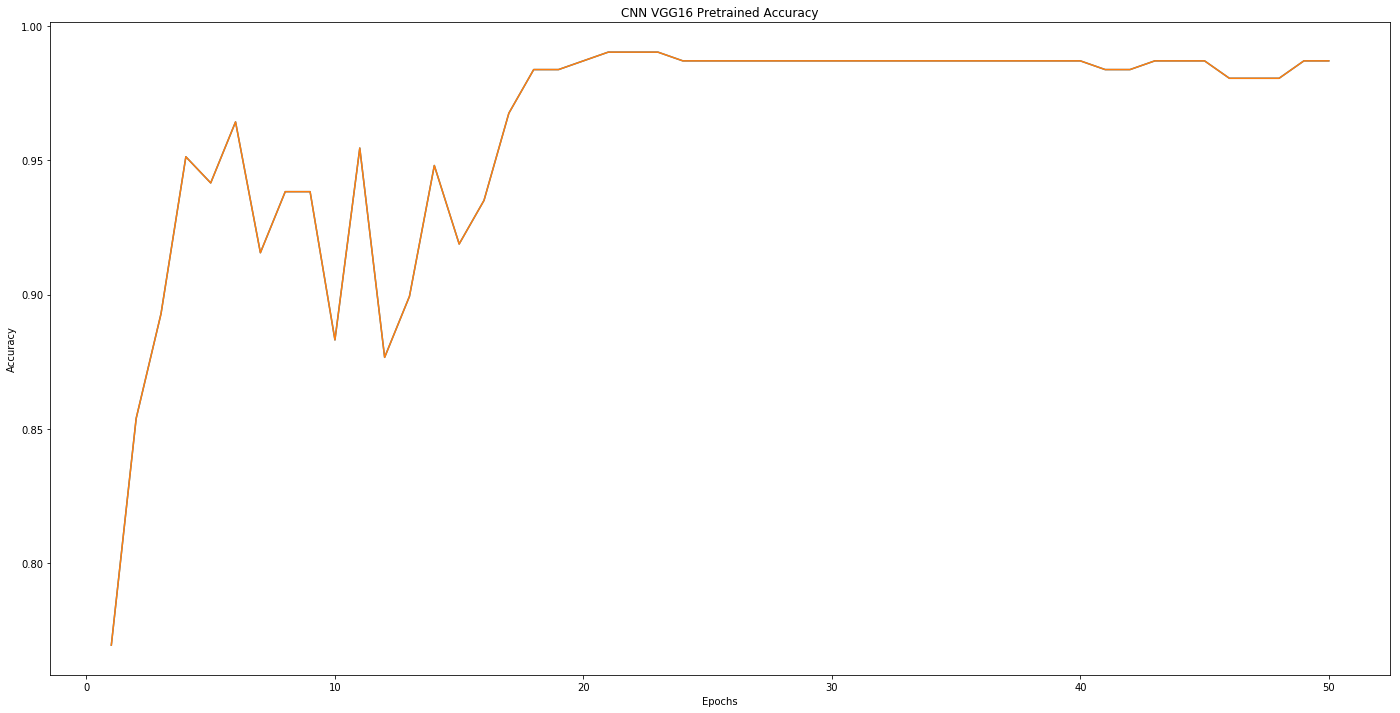

In [12]:
import matplotlib.pyplot as plt

def show_plot(x_data, y_data, x_label, y_label, title):
    plt.subplots(figsize=(12*2, 12))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x_data, y_data)
    plt.plot(x_data, y_data)
    plt.title(title)
    plt.show()
    
acc = np.asarray(history.history['val_accuracy'][:53])

show_plot([i for i in range(1,len(acc)+1)], acc, 'Epochs', 'Accuracy', 'CNN VGG16 Pretrained Accuracy')

# Extract CNN features vector

In [49]:
from keras import backend as K

def feature_model_func(model):
    inp = model.input                                           # input placeholder
    outputs = model.layers[-2].output
    functor = K.function(inp, outputs)   # evaluation function
    return functor

feature_model = feature_model_func(model)




In [50]:
len(feature_model([train_generator[0][0]])[0])

2048

In [56]:
train_generator[0][0].shape

(20, 224, 224, 3)

In [29]:
def label_converter(arr):
    for i in range(len(arr)):
        if arr[i] == 1:
            return i
    return -1

In [64]:
def remove_batches(gen):
    X = []
    y = []
    for i in range(len(gen)):
        im_pred_batch = feature_model(gen[i][0])
        lbl_batch = gen[i][1]
        for j in range(len(im_pred_batch)):
            X.append(im_pred_batch[j])
            y.append(label_converter(lbl_batch[j]))
        
    return np.asarray(X), np.asarray(y)

In [65]:
X_traing, y_training = remove_batches(train_generator)

In [66]:
X_validation, y_validation = remove_batches(validation_generator)

# Saving

In [74]:
cnn_train_path = "npy_saves/cnn_train_imc_50.npy"
cnn_valid_path = "npy_saves/cnn_valid_imc_50.npy"

np.save(cnn_train, X_traing)
np.save(cnn_valid_path, X_validation)

# Testing the accuracy of other models

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

def confusion_matrix(model, X_test, y_test, title):
    disp = plot_confusion_matrix(model, X_test, y_test,
                                cmap=plt.cm.Blues,
                                normalize='true')
    disp.ax_.set_title('Confusion matrix: ' + title)

Random Forest Accuracy: 0.9642857142857143


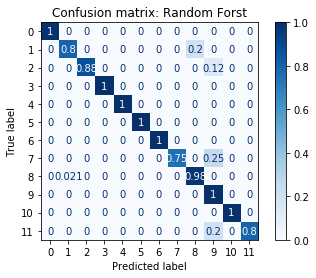

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_traing, y_training)

pred = clf.predict(X_validation)
cnf_matrix = metrics.confusion_matrix(y_validation, pred)
RF_acc = metrics.accuracy_score(y_validation, pred)

print("Random Forest Accuracy:", RF_acc)
confusion_matrix(clf, X_validation, y_validation, "Random Forst")

[LibLinear]Linear SVC accuracy: 0.9772727272727273


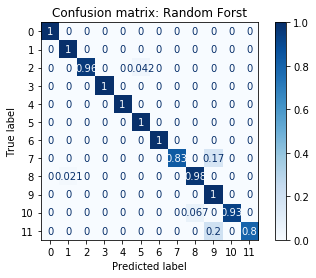

In [72]:
def Linear_SVM_classification(X_train, X_test, y_train, y_test):
    #LinearSVC
    from sklearn.svm import LinearSVC

    svc= LinearSVC(C=100.0, random_state=42, max_iter=1000, verbose=1)
    svc.fit(X_train, y_train)

    svcpred = svc.predict(X_test)
    cnf_matrix = metrics.confusion_matrix(y_test, svcpred)
    SVC_acc = metrics.accuracy_score(y_test, svcpred)
    
    print('Linear SVC accuracy: {}'.format(SVC_acc))
    confusion_matrix(svc, X_test, y_test, "Random Forst")
        
Linear_SVM_classification(X_traing, X_validation, y_training, y_validation)
